In [50]:
validation_set_size = 100
training_set_size = 100
BATCH_SIZE = 512
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 0.0 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 20
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [51]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

Fri Mar 11 11:20:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |    735MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
# Download mat-file from shared drive to your private one if to run in Colab!
drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))
savedParticles = realM + imagM

# This loop unpacks and stores all fields found in the processed video in a 3d-array
for i in range(len(data)):

    roi_data = data[i]['ROI'][0]
    roi_data = np.array(roi_data)[5, :]

    particleROI = np.fft.ifft2(exp_expand(roi_data, shape))
    particleROI = np.fft.fftshift(particleROI)
    particleROI = np.expand_dims(particleROI, axis = -1)

    savedParticles[i,:,:,:] = particleROI
    
training_images = np.stack((np.real(savedParticles[:,:,:,0]), np.imag(savedParticles[:,:,:,0])), axis=-1)[:training_set_size,:,:,:]
validation_set = savedParticles[-validation_set_size:,:,:,:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


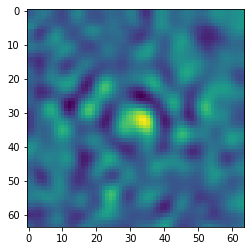

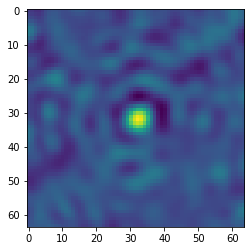

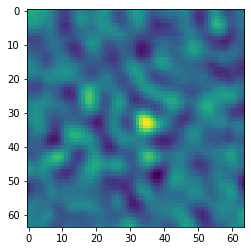

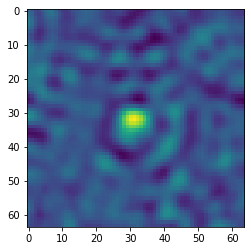

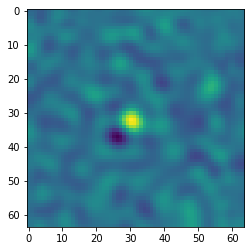

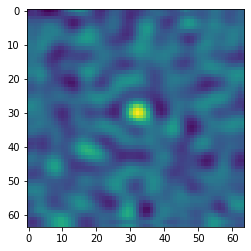

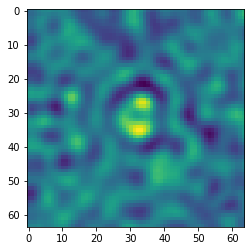

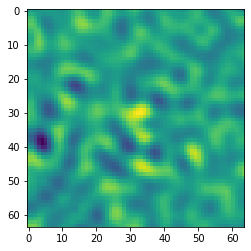

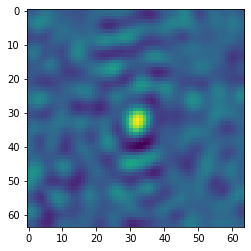

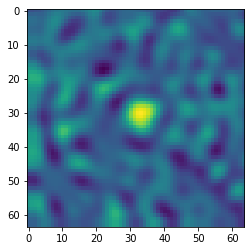

In [53]:
"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*1,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda:np.random.uniform(low=-15, high=15),
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.001)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(-1, args.z, indexes=2)
)

import random
training_set = dt.Value(lambda: random.choice(training_images)) 
#training_set = dt.Value(training_images[0]) 

for _ in range(10):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [54]:
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply
class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [55]:
"""Create models"""
num_outputs = 3

def create_model(custom_layer):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Custom layer": custom_layer}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model

models = [create_model(CustomLayerTwo()), create_model(CustomLayerTwo()), create_model(CustomLayerTwo()), create_model(CustomLayerTwo()), create_model(CustomLayerThree()), create_model(CustomLayerThree()), create_model(CustomLayerThree()), create_model(CustomLayerThree())]

In [56]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201,
)

150/150 [==============================] - 4s 25ms/step - total_loss: 2.8306 - consistency_loss: 0.2274


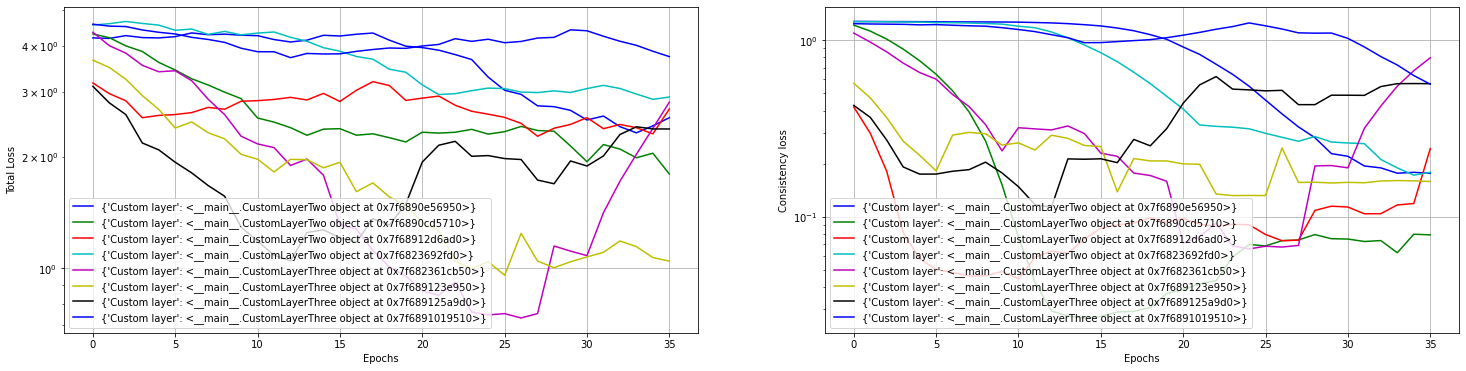

Generating 201 / 200 samples before starting training
Epoch 1/15
150/150 [==============================] - 5s 34ms/step - total_loss: 2.7188 - consistency_loss: 0.1581


KeyboardInterrupt: ignored

In [57]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

while True:
    with generator:
        for model in models:
            h = model.fit(generator, epochs=15, steps_per_epoch=150)
            save_progress(model, h)
        plot_progress(models)
        



In [58]:
#@title
def _propagate_field(field, Tz, z, x, y, K, C, k=2 * np.pi / 0.633):
    """
    Propagate field. Field =  a Complex array of row*col dimension
    """
    Field = np.fft.fft2(field)
    Field = C * Tz * Field
    Field = np.fft.ifft2(Field)

    return Field


def _precalc(field, px, k=2 * np.pi / 0.633):
    """
    Precalculate some constants for propagating field for faster computations.
    """
    yr, xr = field.real.shape

    x = 2 * np.pi / px * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / px * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    # Create a circular disk here.
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return x, y, K, C


def _precalc_Tz(k, zv, K, C):
    return [C * np.fft.fftshift(np.exp(k * 1j * z * (K - 1))) for z in zv]


def propagation_matrix(
    z,
    shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=64,
    wavelength=525e-9,
    pixel_size=1.13e-6,
):
    field = np.zeros(np.array(shape) + padding * 2)
    k = 2 * np.pi / wavelength * 1e-6
    x, y, K, C = _precalc(field, pixel_size * 1e6, k)
    return _precalc_Tz(k, z, K, C)

def pad_fft2(image, padding):
    im = np.copy(image)
    im = np.pad(im, (padding, padding), mode="symmetric")
    return np.fft.fft2(im)

def ft_transformation(image, Tz, Tzinv, i):
    if i < 0:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tzinv
        image *= propfac
    else:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tz
        image *= Tz ** i
    return image

def crop_center(img, cropx, cropy):
    """returns the center of img with size cropx,cropy"""
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

def propagate(image, z):
    """Re-propagate the images using PAS"""
    image_size = len(image[:,0,0])
    propagate_up, propagate_down = propagation_matrix(
        [.05, -.05],
        shape=(image_size, image_size),
        padding=32,
        wavelength=wavelength,
        pixel_size=pixel_size,
        )
    im = image[:,:,0]
    ft_image = pad_fft2(im, 32)
    prop_ft_image = ft_transformation(ft_image, propagate_down, propagate_up, z)
    return np.expand_dims(crop_center(np.fft.ifft2(prop_ft_image),IMAGE_SIZE, IMAGE_SIZE),axis=-1)

{'Custom layer': <__main__.CustomLayerThree object at 0x7f689123e950>}


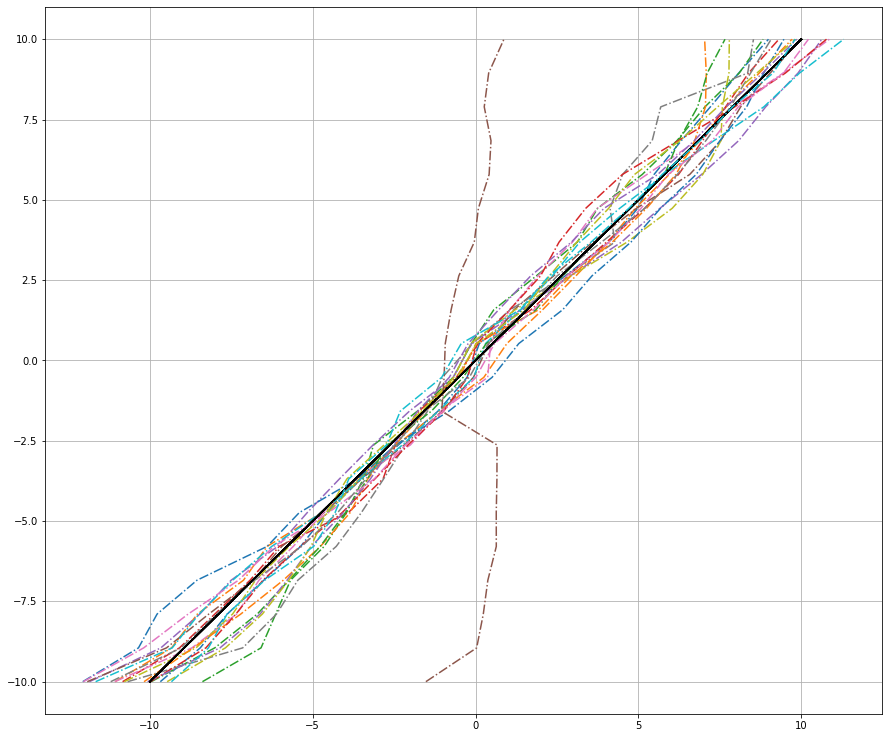

STD: 1.512


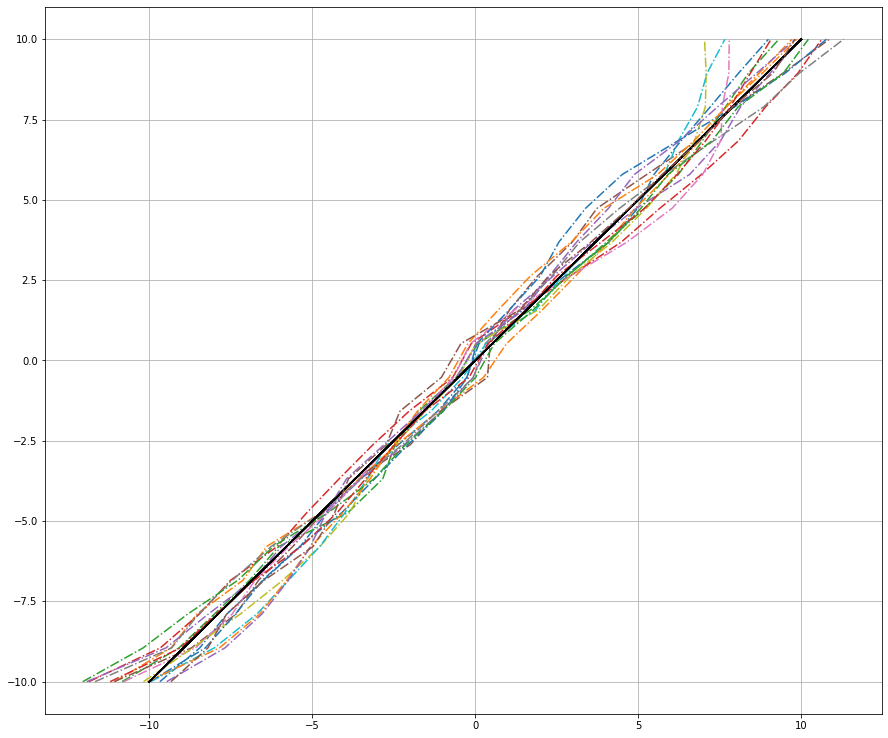

In [62]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets[:,2] *= -0.5
    dets[:,2] -= np.mean(dets[:,2])
    return dets[:,2]

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds():
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[particle_id,:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[particle_id,stack_id,:,:,0]+1j*val_stack[particle_id,stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= -0.5
        dets[:,2] -= np.mean(dets[:,2])

        [print(d) for d in dets]

def evaluate_model(model, val_stack):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i]))
    accs = np.array(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '-.')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()

    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

    ids = np.where(stds < np.mean(stds))
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs[ids].shape[0]):
        ax.plot(prop_range, prop_range, 'k')
        ax.plot(accs[ids][i,:].flatten(), prop_range, '-.')
        ax.grid(True)
        stds.append(np.std(accs[ids][i,:].flatten() - prop_range))
    plt.show()


#########

model = models[-3]
prop_range = np.linspace(-10, 10, 20)
from_id = 0 #31 är exempelvis dålig..
num_samples = 20
stack_id = len(prop_range)//2

print(model.specs)
val_stack = create_validation_stack(validation_set, prop_range)
evaluate_model(model, val_stack)
#plot_preds()
#show_id = 1

#fig, ax = plt.subplots(1,1, figsize=(15,13))
#plt.imshow(np.abs(val_stack[show_id,stack_id,:,:,0]+1j*val_stack[show_id,stack_id,:,:,1]), cmap="bone")
#plt.show()